In [2]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
from analysis import collection, analysis, emg, plot
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
import matplotlib as mpl
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture
from sklearn.metrics import silhouette_score
from joblib import dump, load

%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams.update({'axes.labelsize': 16})

image_path = Path("/Users/spencer/phd/phd/images/")

In [3]:
def make_lognormal_mean(normal_mean, normal_covariance):
    dim = normal_mean.shape[0]
    assert dim >= normal_mean.shape[1]
    assert dim == normal_covariance.shape[0] and dim == normal_covariance.shape[1]
    return np.exp(normal_mean + 0.5*np.diag(normal_covariance).reshape(-1,1))

def make_lognormal_covariance(normal_mean,normal_covariance):
    dim = normal_mean.shape[0]
    assert dim >= normal_mean.shape[1]
    assert dim == normal_covariance.shape[0] and dim == normal_covariance.shape[1]
    cov = np.zeros(shape=(dim,dim))
    cov[:] = np.nan
    for i in range(dim):
        for j in range(dim):
            cov[i,j] = (np.exp(normal_mean[i] + normal_mean[j] + 0.5*(normal_covariance[i,i] + normal_covariance[j,j]))*(np.exp(normal_covariance[i,j]) - 1)).reshape(-1)[0]
    assert np.all(np.isfinite(cov))
    return cov

## test with fake data

(10000, 64)
(64,) (64, 1) (64,) (64, 1)


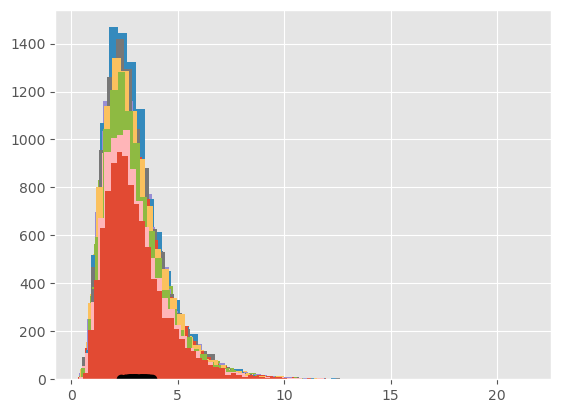

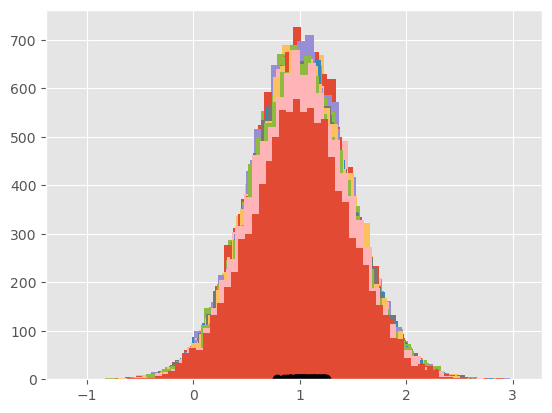

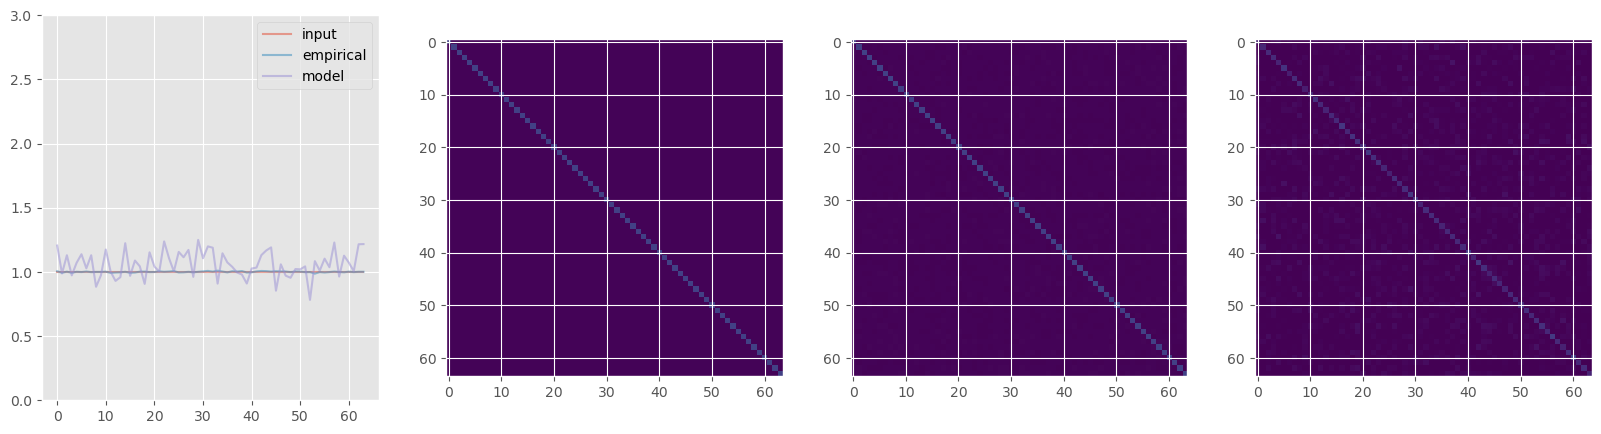

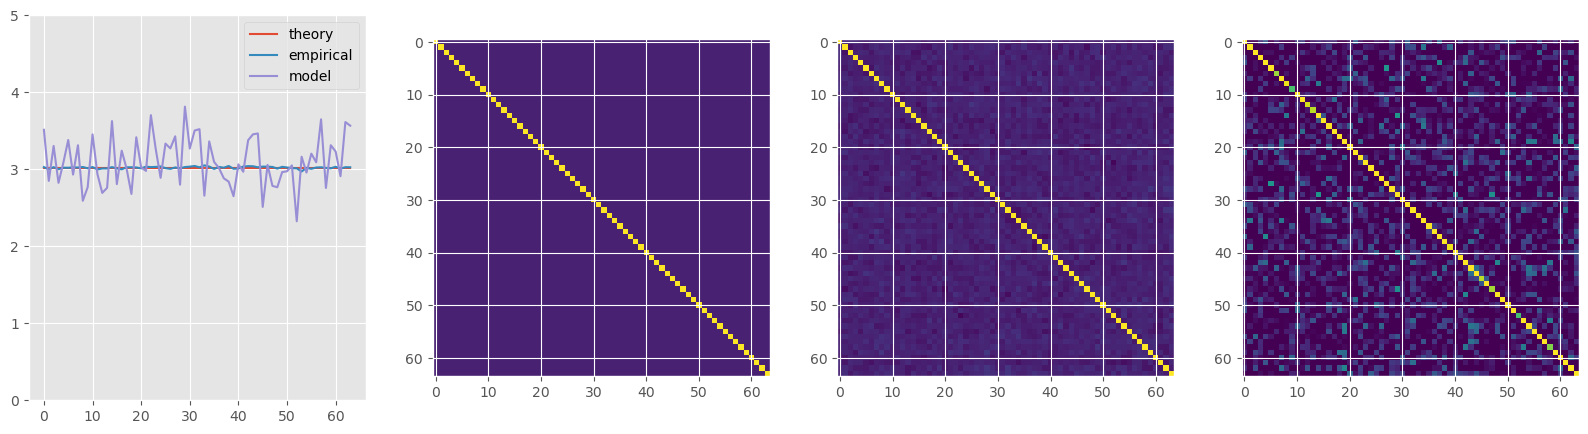

In [5]:
# sample normal data (log transformed!)
d = np.random.normal(0,1,size=(2,64))
normal_mean = np.ones(shape=(64,1))
normal_cov = np.ones(shape=(64,64))*0.01 + np.eye(64)*0.2
data = np.random.multivariate_normal(normal_mean.reshape(-1),normal_cov,size=(10000))
print(data.shape)

mean_empirical = np.mean(data,axis=0)
cov_empirical = np.cov(data.T)

log_mean_theory = make_lognormal_mean(normal_mean,normal_cov)
log_cov_theory = make_lognormal_covariance(normal_mean,normal_cov)

log_data = np.exp(data)
log_mean_empirical = np.mean(log_data,axis=0)
log_cov_empirical = np.cov(log_data.T)

model = BayesianGaussianMixture(n_components=12,
                                weight_concentration_prior_type='dirichlet_process',
                                weight_concentration_prior=1.e-8,
                                max_iter=200,
                                n_init=3,
                                warm_start=True,
                                random_state=0,
                                )
model.fit(data)

# convert normal moments to lognormal moments (recover lognormal from log'd data)
# this is exponential map from normal to lognormal
log_mean_model = make_lognormal_mean(model.means_[0].reshape(-1,1),model.covariances_[0])
log_cov_model = make_lognormal_covariance(model.means_[0].reshape(-1,1),model.covariances_[0])

plt.figure()
for i, samples in enumerate(log_data.T):
    plt.hist(samples,bins=50)
    plt.plot(log_mean_model[i],[0],'ko')

plt.figure()
for i, samples in enumerate(data.T):
    plt.hist(samples,bins=50)
    plt.plot([model.means_[0,i]],[0],'ko')

print(model.means_[0].shape,log_mean_theory.shape,log_mean_empirical.shape,log_mean_model.shape)

# compare normal data and normal model
normal_fig, axes = plt.subplots(1,4,figsize=(20,5))
axes[0].plot(normal_mean,alpha=0.5,label="input")
axes[0].plot(mean_empirical,alpha=0.5,label="empirical")
axes[0].plot(model.means_[0],alpha=0.5,label="model")
axes[0].legend()
axes[0].set_ylim([0,3])
axes[1].imshow(normal_cov,vmin=0,vmax=1.1)
axes[2].imshow(cov_empirical,vmin=0,vmax=1.1)
axes[3].imshow(model.covariances_[0],vmin=0,vmax=1.1)

normal_fig, axes = plt.subplots(1,4,figsize=(20,5))
axes[0].plot(log_mean_theory,label="theory")
axes[0].plot(log_mean_empirical,label="empirical")
axes[0].plot(log_mean_model,label="model")
axes[0].legend()
axes[0].set_ylim([0,5])
axes[1].imshow(log_cov_theory,vmin=0,vmax=1)
axes[2].imshow(log_cov_empirical,vmin=0,vmax=1)
axes[3].imshow(log_cov_model,vmin=0,vmax=1)

In [6]:
def transform_mean(decoder, mean):
    return decoder @ mean

def transform_covariance(decoder, covariance):
    return decoder @ covariance @ decoder.T

In [11]:
def plot_mean(mean,ax=None):
    if not ax is None:
        ax.plot(mean[0],mean[1],"o")
    else:
        plt.gca().plot(mean[0],mean[1],'o')

def confidence_ellipse(center, cov, ax, n_std=3.0, edgecolor="k", facecolor='none', **kwargs):
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        edgecolor=edgecolor,
        **kwargs)
    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(center[0], center[1])

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

<Figure size 640x480 with 0 Axes>

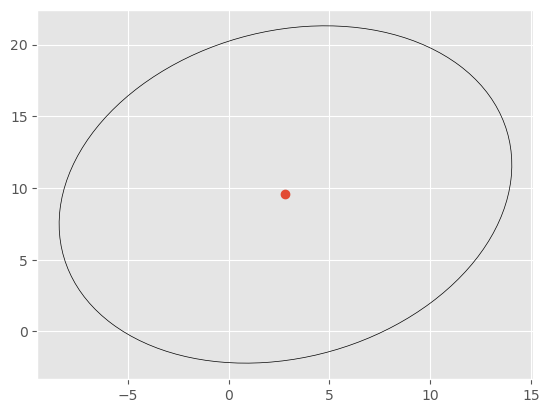

<Figure size 640x480 with 0 Axes>

In [15]:
decoder = np.random.standard_normal(size=(2,64))

plt.figure()
plot_mean(transform_mean(decoder,normal_mean))
confidence_ellipse(transform_mean(decoder,normal_mean), transform_covariance(decoder, normal_cov), plt.gca())

plt.figure()


In [4]:
gaussians = [np.random.multivariate_normal(np.zeros(shape=(64,)),cov=np.eye(64),size=500),
             np.random.multivariate_normal(10*np.ones(shape=(64,)),cov=np.eye(64),size=500),
             np.random.multivariate_normal(-10*np.ones(shape=(64,)),cov=np.eye(64),size=500)]
samples = np.row_stack(gaussians)

# 64 -> 2 decoder
d = np.random.normal(0,1,(2,64))

model = BayesianGaussianMixture(n_components=3,
                                weight_concentration_prior_type='dirichlet_process',
                                weight_concentration_prior=1.e-8,
                                # init_params="k-means++",
                                max_iter=200,
                                n_init=3,
                                warm_start=True,
                                random_state=0,
                                )
model.fit(samples)

BayesianGaussianMixture(max_iter=200, n_components=3, n_init=3, random_state=0,
                        warm_start=True, weight_concentration_prior=1e-08)

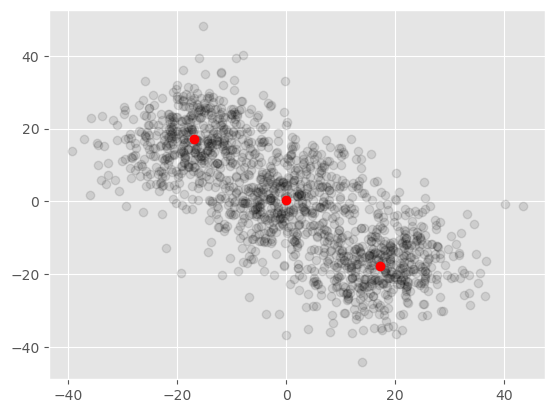

In [5]:
for i,g in enumerate(gaussians):
    s = d @ g.T
    plt.plot(s[0],s[1],'ko',alpha=0.1)
for mean_ in model.means_:
    mean = d @ mean_
    plt.plot(mean[0],mean[1],'ro')

# inspect real data

In [6]:
from sklearn.base import clone

def fit_mixture_models(data,components,random_state=0):
    assert len(data.shape) == 2
    assert data.shape[1] == 64
    assert data.shape[0] > data.shape[1]
    models = []
    for num_components in components:
        print(f"Fitting {num_components} components")
        model = BayesianGaussianMixture(n_components=num_components,
                                        weight_concentration_prior_type='dirichlet_process',
                                        weight_concentration_prior=1.e-8,
                                        max_iter=200,
                                        n_init=3,
                                        warm_start=True,
                                        random_state=random_state,
                                        )
        model.fit(data) 
        models.append(model)
        model = clone(model)
    return models

In [7]:
def log_emg_data(samples):
    print(samples.shape)
    samples[:,56] = np.mean(samples[:,(56-8,56-16)],axis=1)
    print(samples.shape)
    return np.log(samples)

In [8]:
def compute_silhouette_scores(models,data):
    assert len(data.shape) == 2
    assert data.shape[1] == 64
    assert data.shape[0] > data.shape[1]
    silhouette_scores = []
    for model in models:
        silhouette_scores += [silhouette_score(data, model.predict(data))]
    return silhouette_scores

In [9]:
import pickle
with open('olympics_subjects.pkl', 'rb') as handle:
    subjects = pickle.load(handle)
len(subjects)

46

In [10]:
mean_rewards = np.load("subject_rewards.npy")
subject_idx = np.argsort(mean_rewards)[-10]
print(subject_idx)

stack = np.load(f"filtered_stacks/filtered_stack_{subject_idx}.npy")
samples = stack.transpose((0,1,3,2)).reshape(-1,64)
log_samples = log_emg_data(samples)

samples = analysis.remove_nan_rows(samples)
log_samples = analysis.remove_nan_rows(log_samples)

print(samples.shape, log_samples.shape)

17
(1080000, 64)
(1080000, 64)
(173096, 64) (173096, 64)


In [40]:
decoder = subjects[subject_idx].decoder[-2:,:]

N_COMPONENTS = 12

for random_state in range(1):
    model = fit_mixture_models(log_samples,components=[N_COMPONENTS],random_state=random_state)[0]
    score = compute_silhouette_scores([model],log_samples)[0]

Fitting 12 components


In [12]:
log_means = []
log_covs = []
for mean, cov in zip(model.means_, model.covariances_):
    log_means += [make_lognormal_mean(mean.reshape(-1,1),cov)]
    log_covs += [make_lognormal_covariance(mean.reshape(-1,1),cov)]

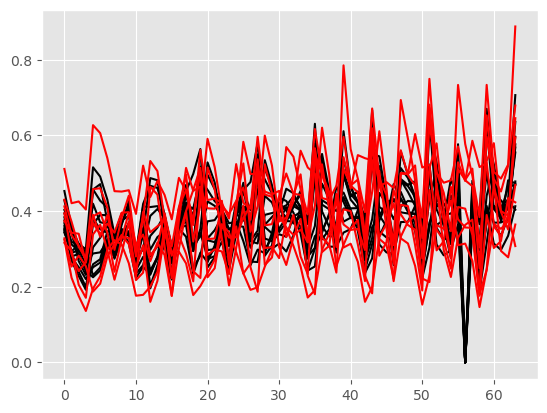

In [13]:
target_means = np.nanmean(stack,axis=(0,3))
for tm in target_means:
    plt.plot(tm,'k')
for lm in log_means:
    plt.plot(lm,'r')

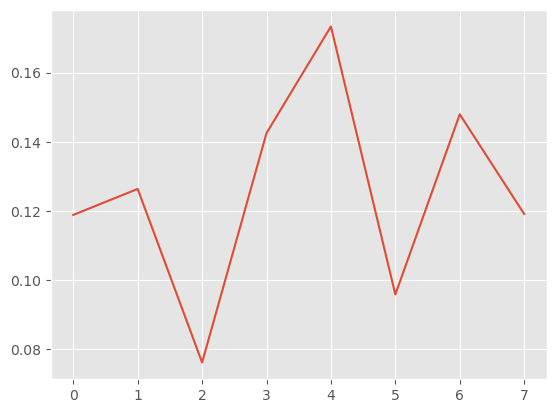

In [14]:
plt.plot(model.weights_)

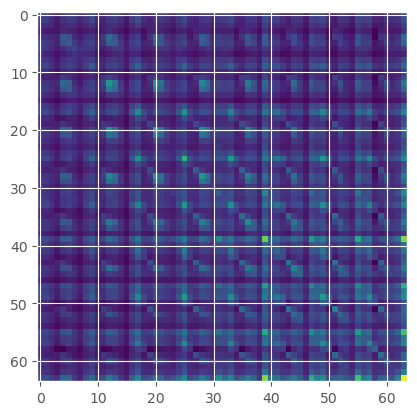

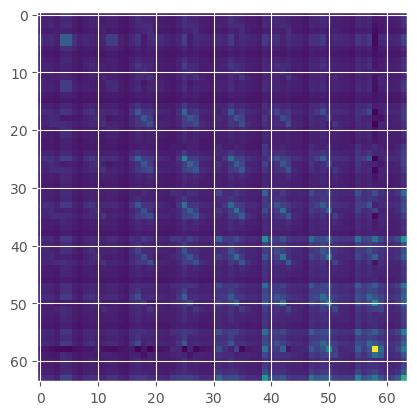

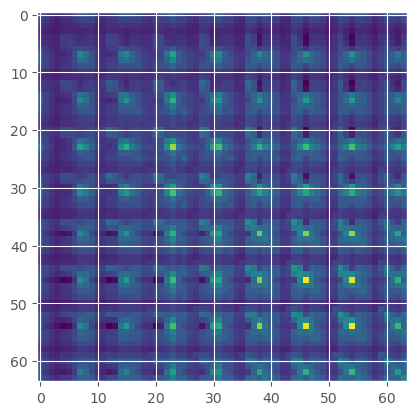

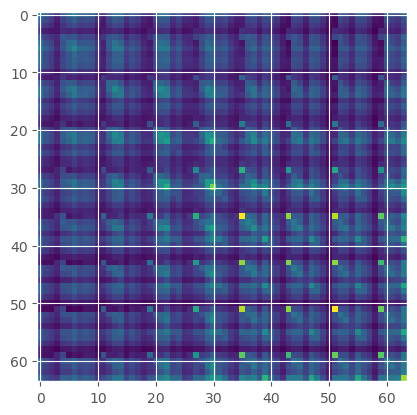

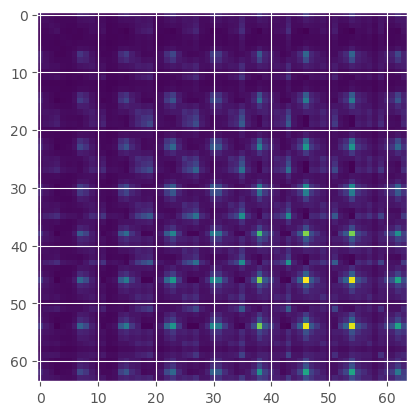

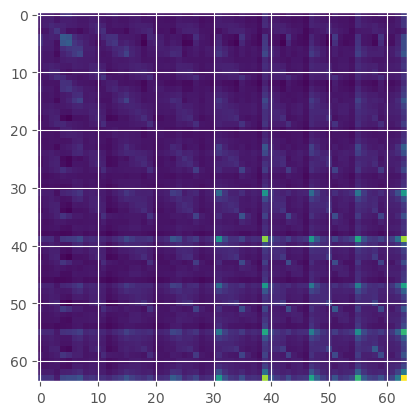

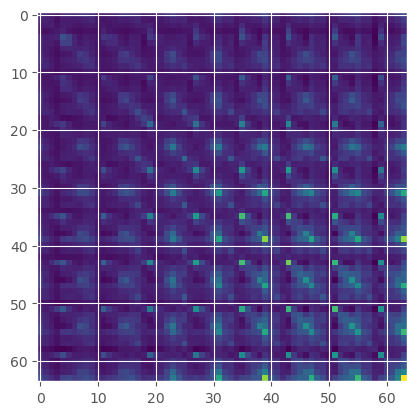

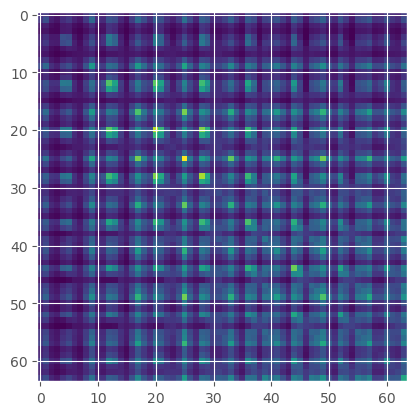

In [15]:
for mc in log_covs:
    plt.figure()
    plt.imshow(mc)

8 8


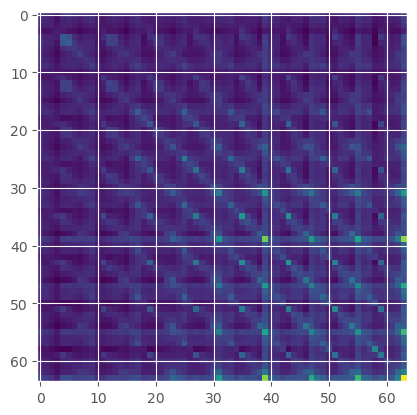

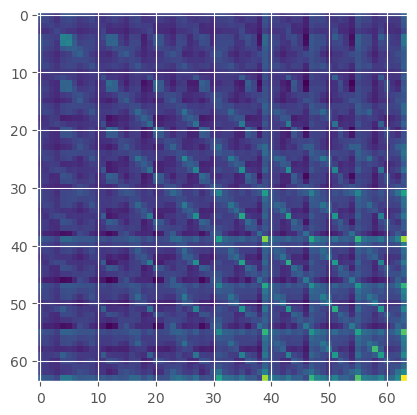

In [16]:
reconstructed_cov = np.zeros((64,64))
print(len(log_covs),len(model.weights_))
for cov, weight in zip(log_covs,model.weights_):
    reconstructed_cov += weight*cov
plt.imshow(reconstructed_cov)
plt.figure()
plt.imshow(np.cov(samples.T))

In [17]:
model_samples = model.sample(100000)[0]
model_trajectory_samples = decoder @ np.exp(model_samples.T)

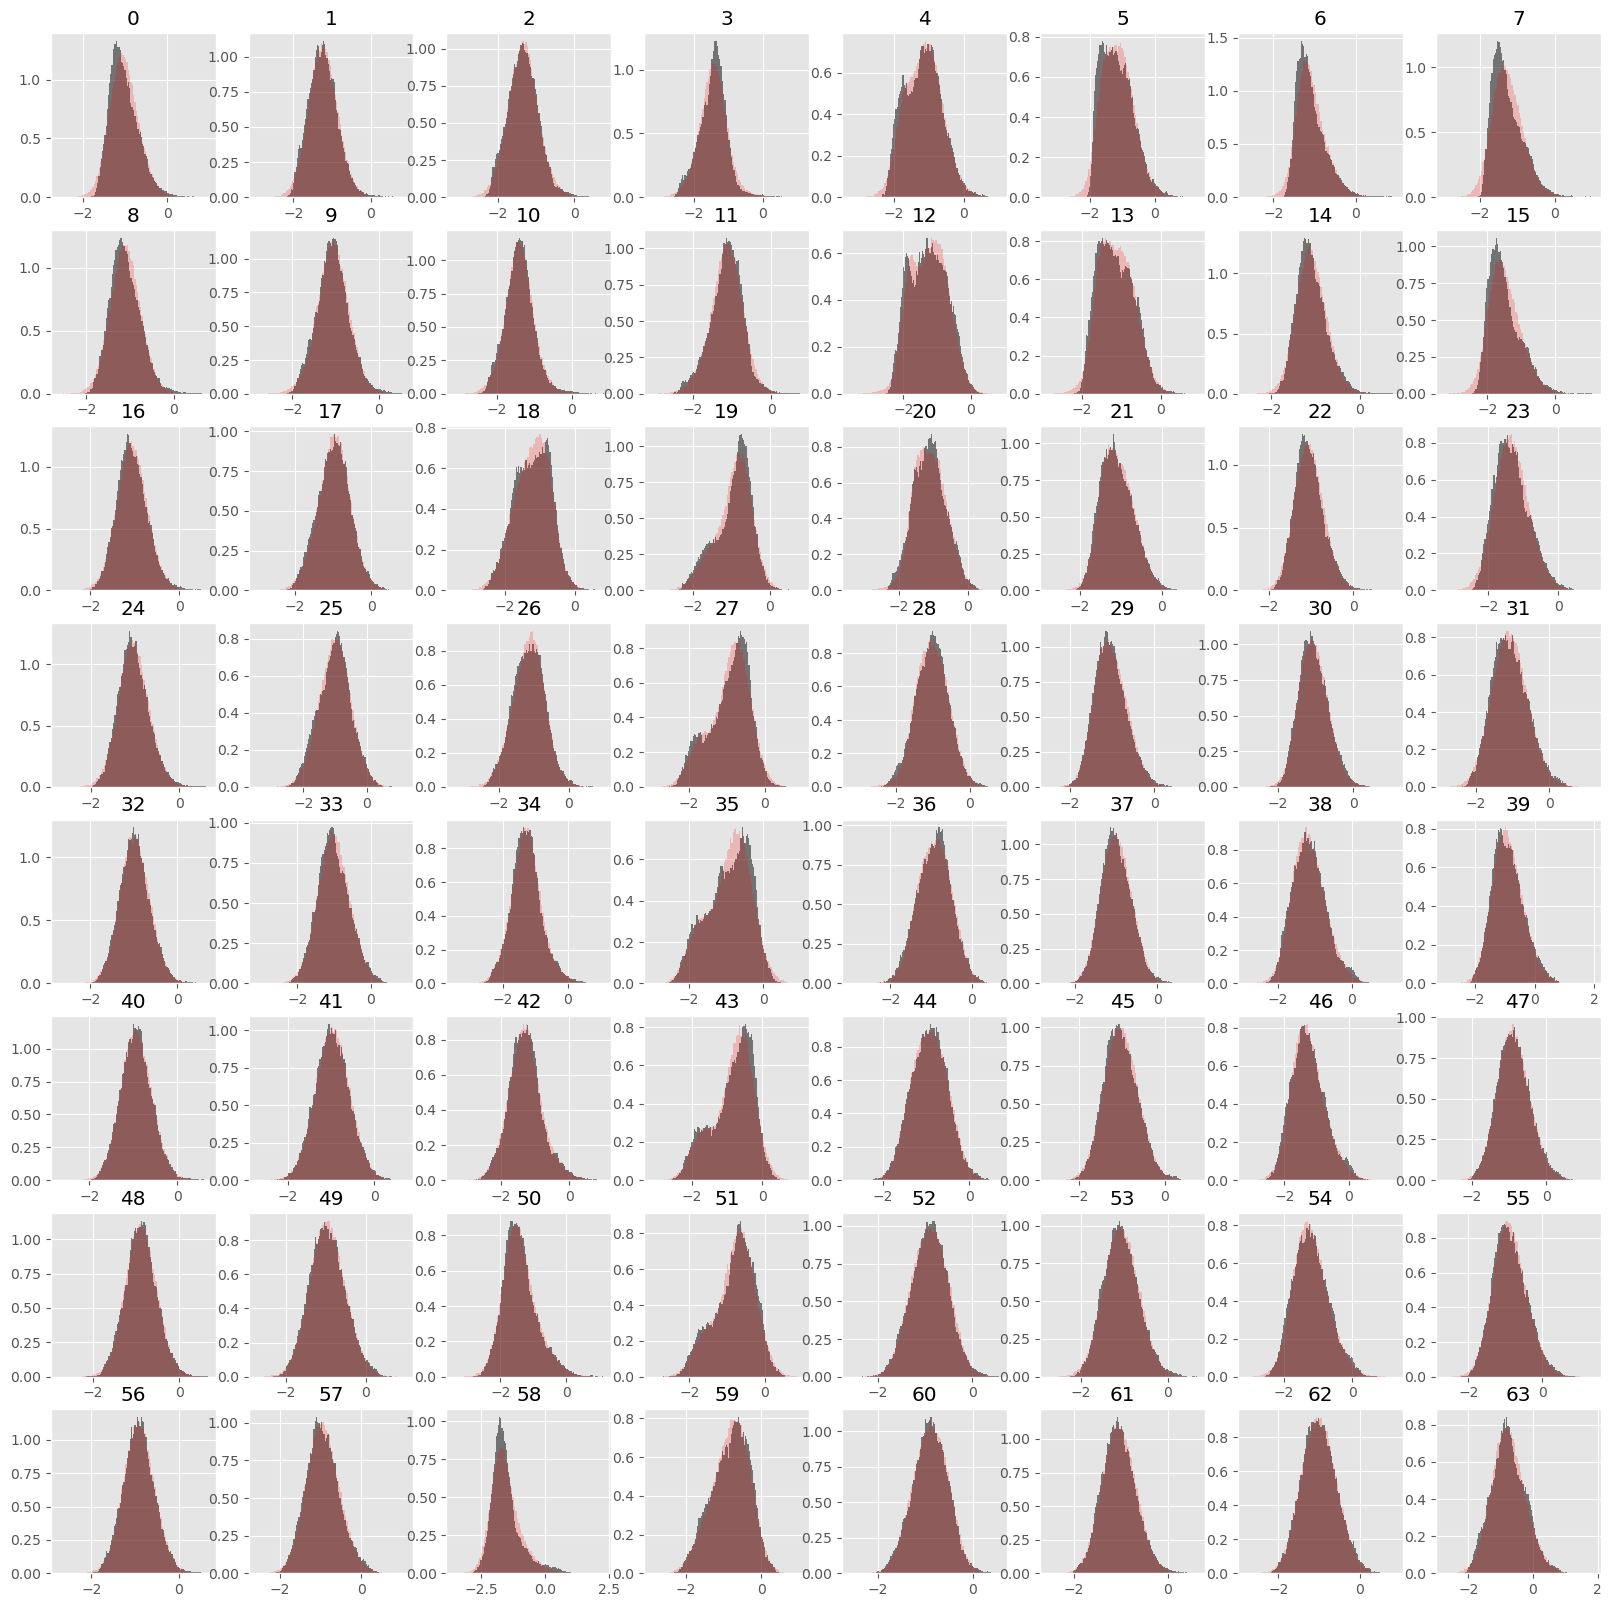

In [18]:
fig, axes = plt.subplots(8,8,figsize=(20,20))
axes = axes.ravel()
for ch in range(64):
    axes[ch].hist(log_samples[:,ch],color="k",bins=100,alpha=0.5,density=True)
    axes[ch].hist(model_samples[:,ch],color="r",bins=100,alpha=0.2,density=True)    
    axes[ch].set_title(ch)

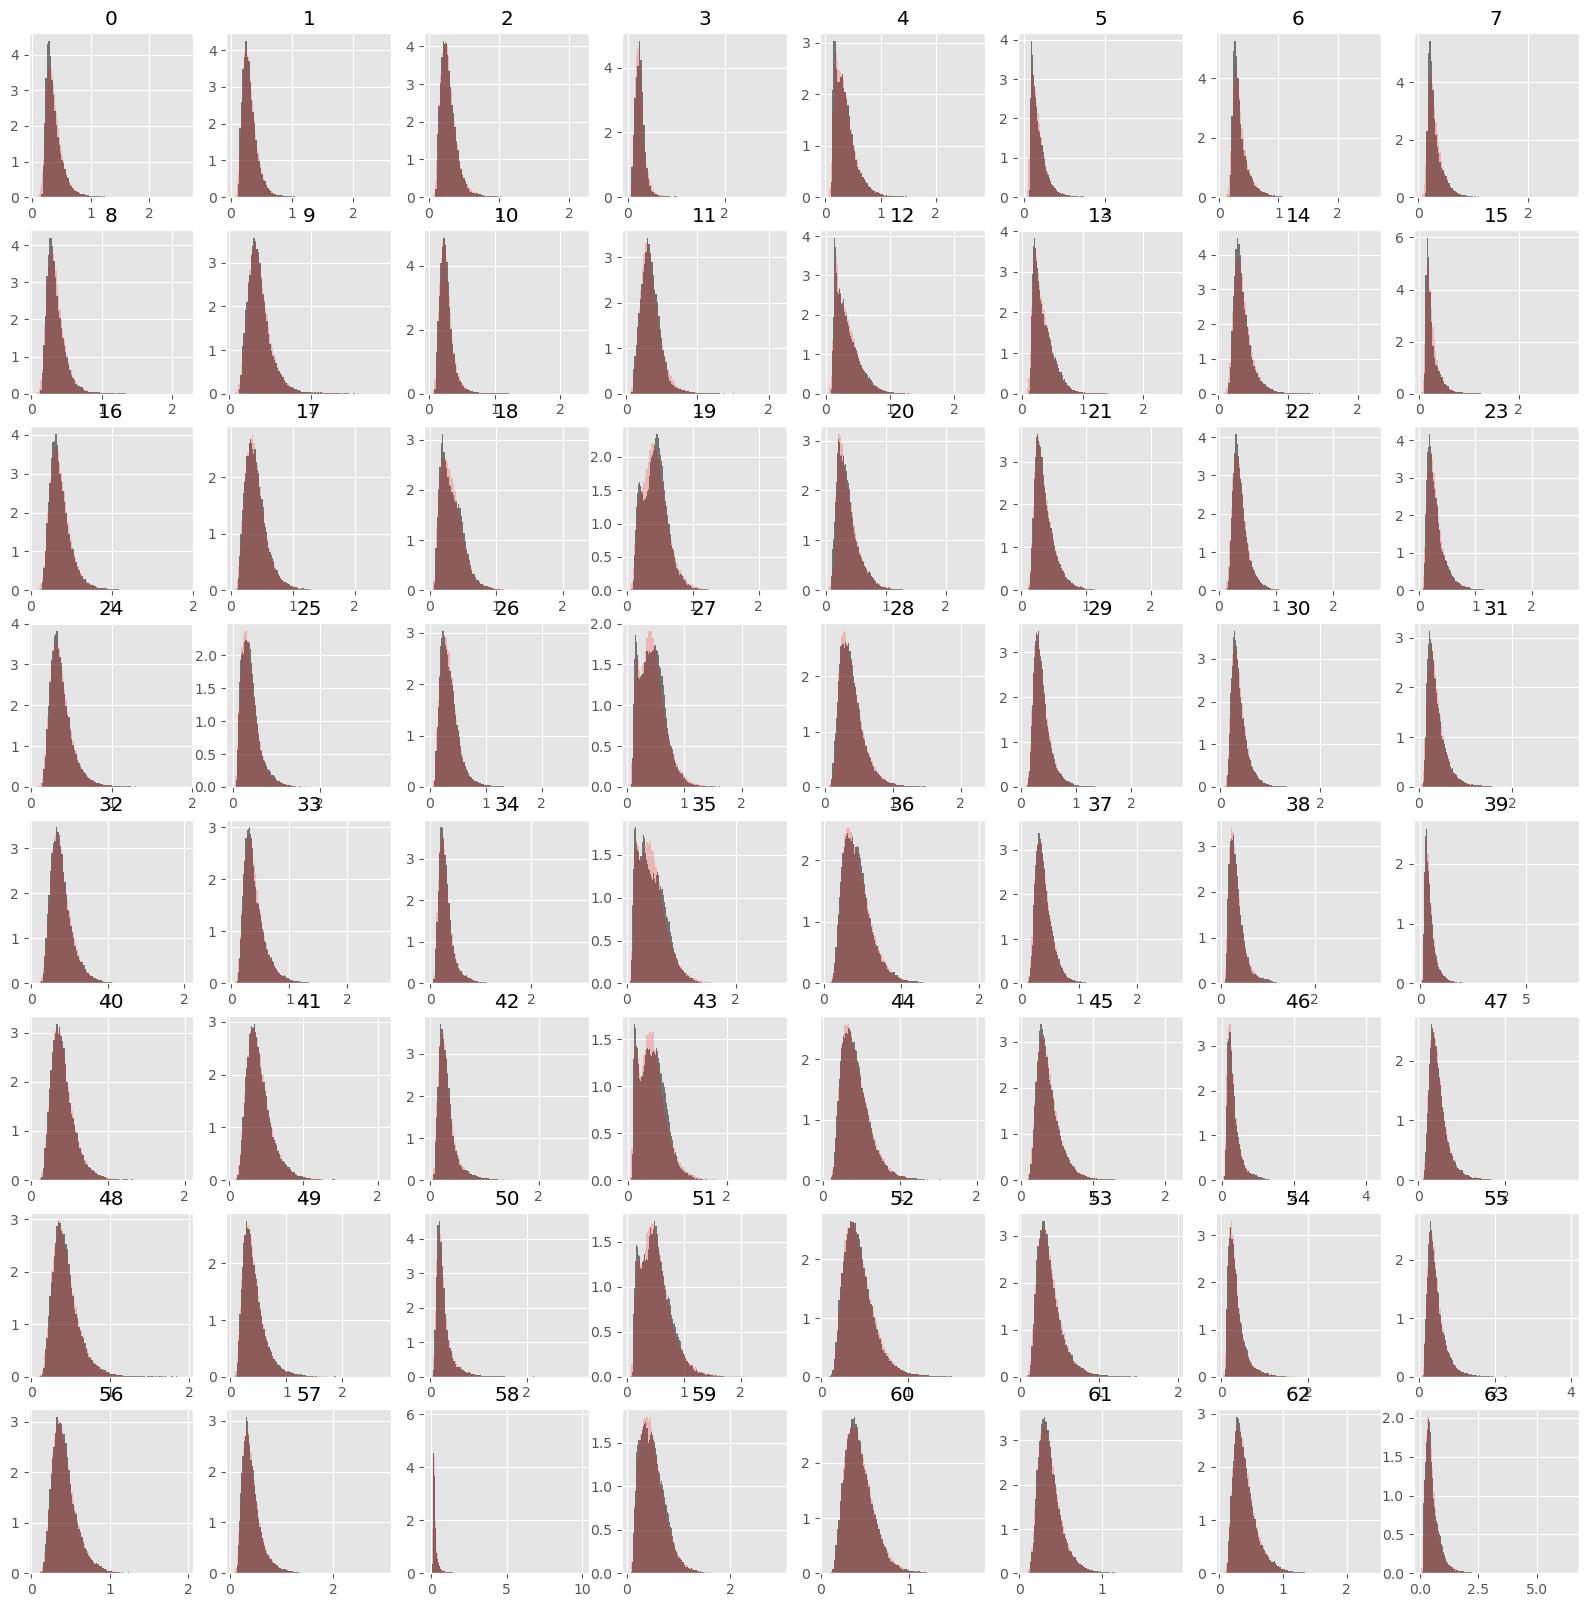

In [19]:
fig, axes = plt.subplots(8,8,figsize=(20,20))
axes = axes.ravel()
for ch in range(64):
    axes[ch].hist(samples[:,ch],color="k",bins=100,alpha=0.5,density=True)
    axes[ch].hist(np.exp(model_samples[:,ch]),color="r",bins=100,alpha=0.2,density=True)    
    axes[ch].set_title(ch)

In [20]:
trajectory_stacks = np.load("subject_filtered_trajectory_stacks.npy")
print(trajectory_stacks.shape)

(46, 45, 12, 2, 2000)


In [21]:
trajectory_samples = analysis.remove_nan_rows(trajectory_stacks[subject_idx].transpose(0,1,3,2).reshape(-1,2))
trajectory_samples.shape

(171981, 2)

In [22]:
subject_target_hits = []
target_hits = np.zeros(shape=(12))
sessions = subjects[subject_idx].tasks["center_hold"].sorted_sessions()
for target_no in range(1,13):
    target_hit_count = 0
    for session in sessions:
        for trial in session.sorted_trials():
            if target_no == trial.target_number and trial.outcome == "Hit":
                target_hit_count += 1
    target_hits[target_no-1] = target_hit_count
subject_target_hits.append(target_hits)
subject_target_hits = np.array(subject_target_hits).reshape(-1)
print(subject_target_hits)

[39. 34. 35. 34. 24. 25. 30. 33. 38. 40. 38. 41.]


In [23]:
def confidence_ellipse(center, cov, ax, n_std=3.0, edgecolor="k", facecolor='none', **kwargs):
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        edgecolor=edgecolor,
        **kwargs)
    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(center[0], center[1])

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def transform_mean(decoder, mean):
    return decoder @ mean

def transform_covariance(decoder, covariance):
    return decoder @ covariance @ decoder.T

/tmp/ipykernel_28817/2271519864.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(
/tmp/ipykernel_28817/2271519864.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(


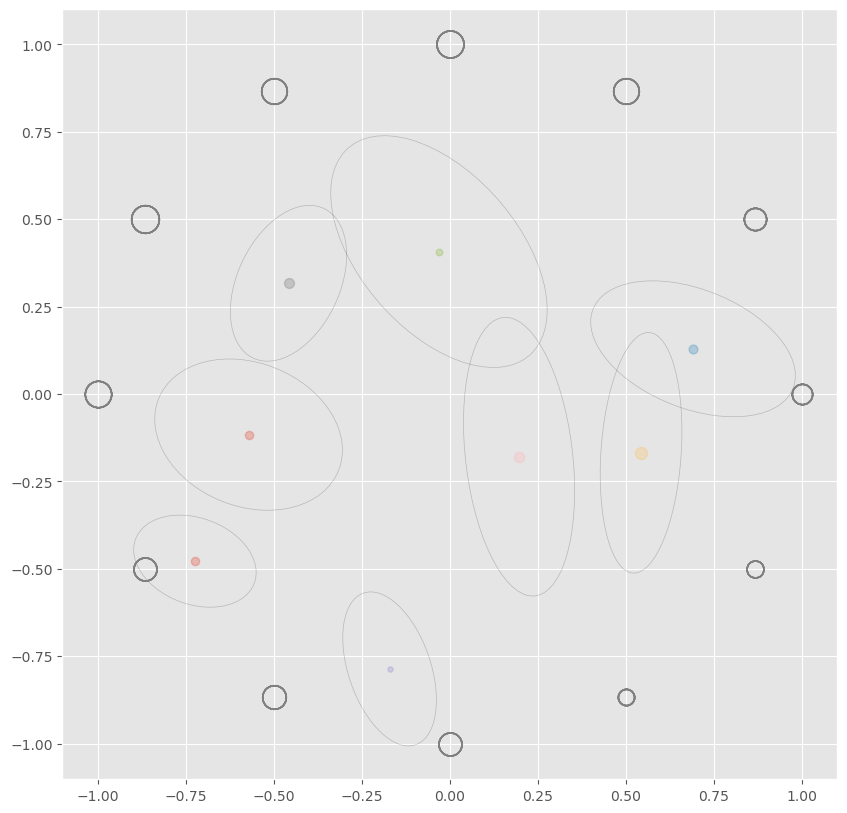

In [24]:
from matplotlib.markers import MarkerStyle

def plot_weighted_targets(ax, weights, style="ko"):
    m = MarkerStyle("o", fillstyle="none")
    theta = (np.linspace(0, 2 * np.pi, 13) + np.pi)[:-1]
    for t, w in zip(theta, weights):
        ax.plot(
            np.cos(t),
            np.sin(t),
            style,
            marker=m,
            markersize=w*200,
            color="grey",
        )
    
plt.figure(figsize=(10,10))
for mean, covariance, weight in zip(log_means, log_covs, model.weights_):
    tm = transform_mean(decoder, mean)
    tc = transform_covariance(decoder, covariance)
    plt.plot(tm[0],tm[1],'o',zorder=100,markersize=weight*50,alpha=0.3)
    plot_weighted_targets(plt.gca(), weights = subject_target_hits/subject_target_hits.sum())
    confidence_ellipse(tm,tc,plt.gca(),n_std=0.5,alpha=0.2)

/home/spencer/phd/analysis/notebooks/../analysis/plot.py:72: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ko" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(
/home/spencer/phd/analysis/notebooks/../analysis/plot.py:72: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko" (-> color='k'). The keyword argument will take precedence.
  ax.plot(


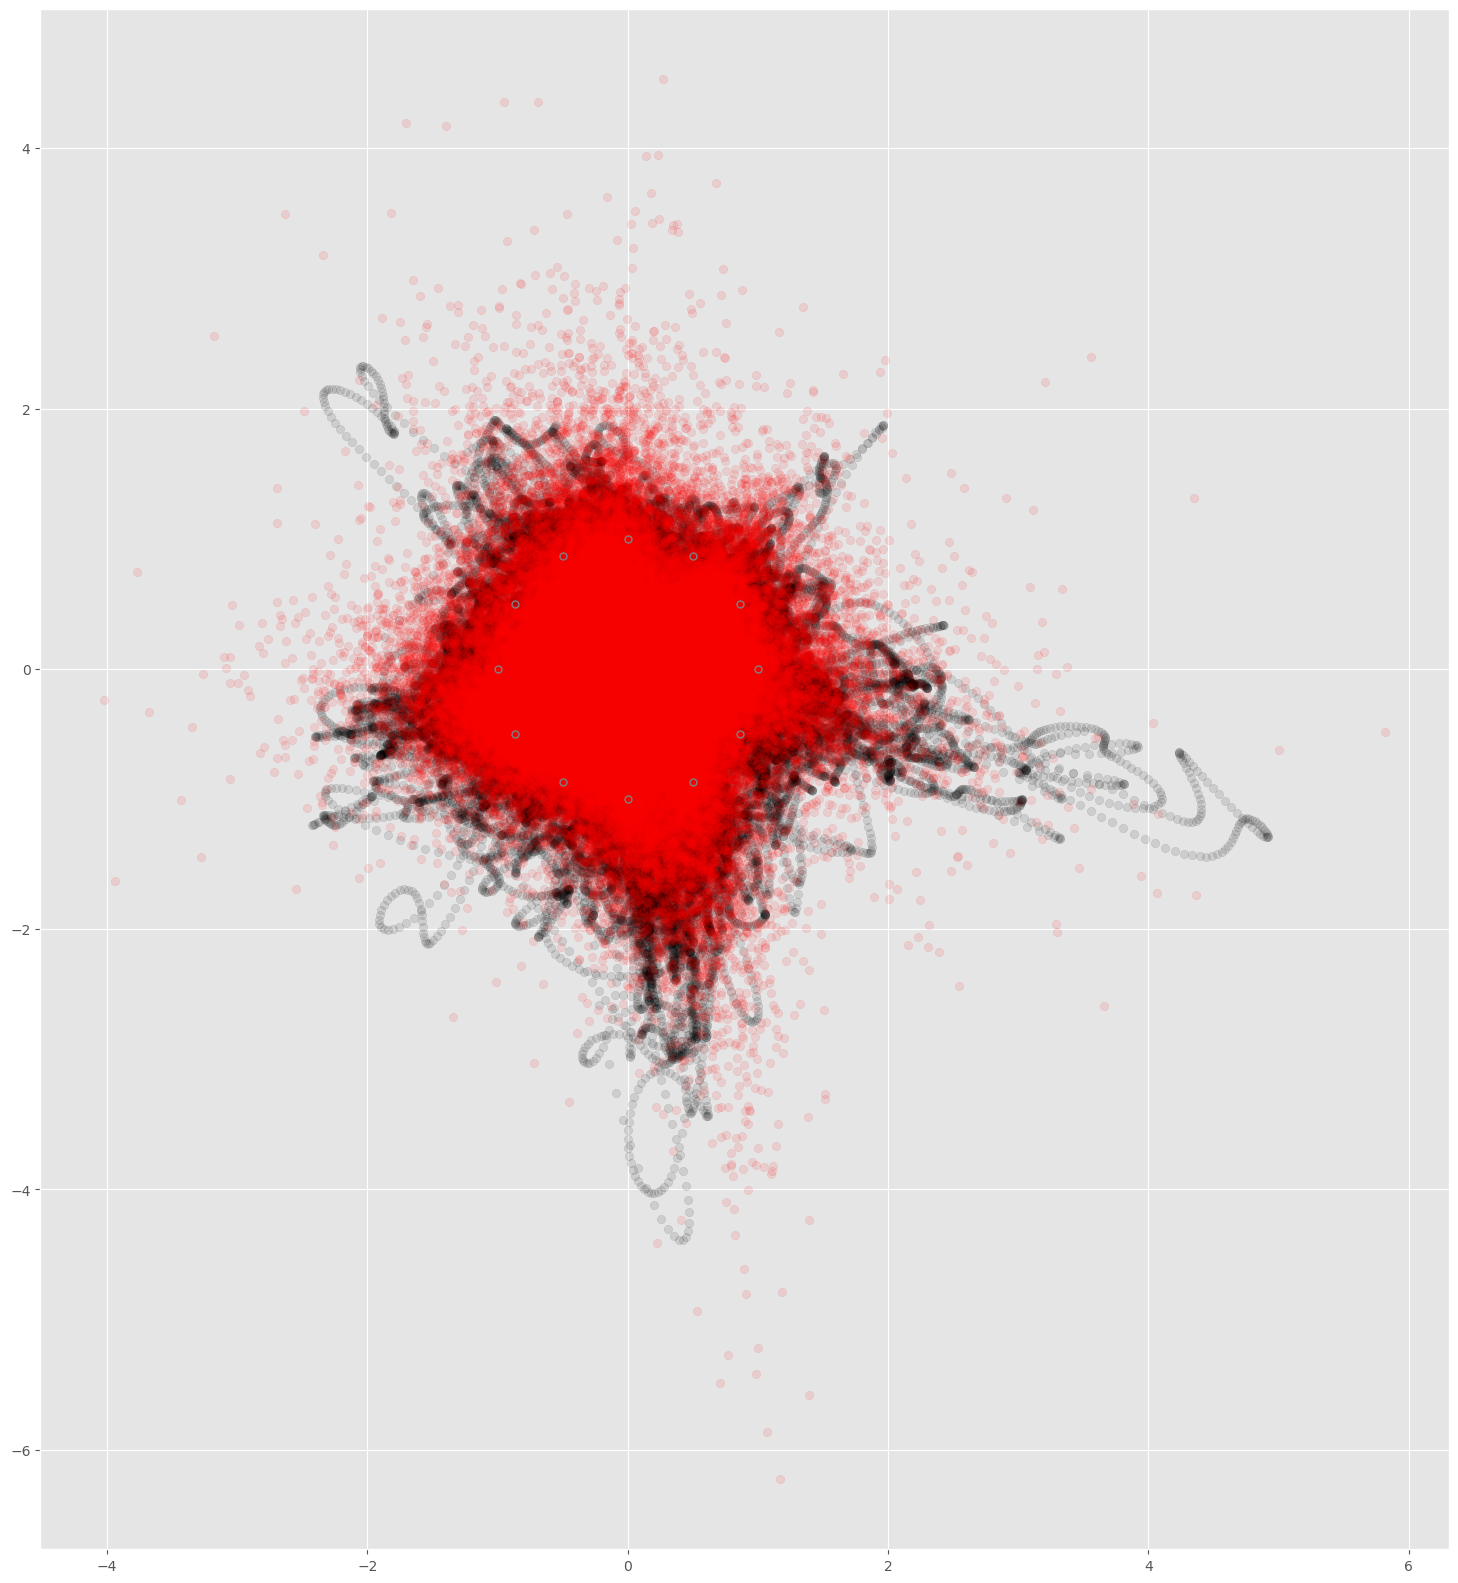

In [25]:
plt.figure(figsize=(20,20))
trajectory_samples = decoder @ samples.T
plt.scatter(trajectory_samples[0],trajectory_samples[1],color="k",alpha=0.1)
plt.scatter(model_trajectory_samples[0],model_trajectory_samples[1],color="r",alpha=0.1)
# plt.scatter(trajectory_samples[:,0],model_trajectory_samples[1],color="r",alpha=0.3)
plt.gca().set_aspect("equal")
plot.plot_targets(plt.gca())

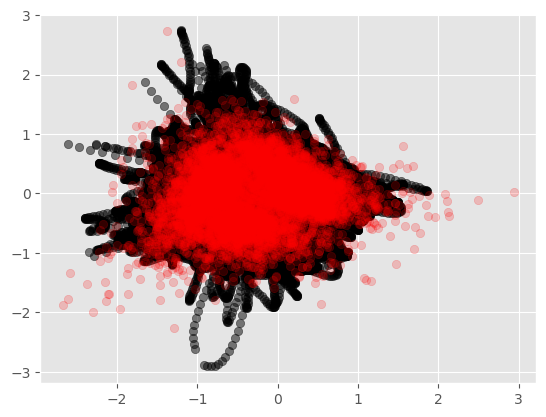

In [74]:
S = decoder @ samples.T
plt.scatter(S[0],S[1],color="k",alpha=0.5)
plt.scatter(T[0],T[1],color="r",alpha=0.2)
plot.plot_ta